In [1]:
import pickle
import numpy as np

In [2]:
with open ('train_qa.txt','rb') as f:
    train_data=pickle.load(f)

In [3]:
with open ('test_qa.txt','rb') as f:
    test_data=pickle.load(f)

In [4]:
type(test_data)

list

In [5]:
len(train_data)

10000

In [6]:
len(test_data)

1000

In [9]:
' '.join(train_data[0][0]) # prints out the story

'Mary moved to the bathroom . Sandra journeyed to the bedroom .'

In [10]:
' '.join(train_data[0][1])

'Is Sandra in the hallway ?'

In [11]:
' '.join(train_data[0][2])

'n o'

In [12]:
all_data=test_data+train_data

In [13]:
len(all_data)

11000

In [15]:
set(train_data[0][0])

{'.',
 'Mary',
 'Sandra',
 'bathroom',
 'bedroom',
 'journeyed',
 'moved',
 'the',
 'to'}

In [16]:
vocab=set()

for story,question,answer in all_data:
    vocab = vocab.union(set(story))
    vocab=vocab.union(set(question))

In [17]:
vocab.add('yes')

In [18]:
vocab.add('no')

In [19]:
vocab_len=len(vocab)+1

In [20]:
vocab_len

38

In [21]:
#Longest story
all_story_lens=[len(data[0]) for data in all_data]

In [23]:
max_story_len=max(all_story_lens)

In [24]:
max_question_len=max([len(data[1]) for data in all_data])

In [25]:
max_question_len

6

In [27]:
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

In [31]:
tokenizer=Tokenizer(filters=[])
tokenizer.fit_on_texts(vocab)

In [32]:
tokenizer.word_index

{'left': 1,
 'is': 2,
 'discarded': 3,
 'put': 4,
 '?': 5,
 'up': 6,
 'journeyed': 7,
 'bedroom': 8,
 'travelled': 9,
 'picked': 10,
 'hallway': 11,
 'to': 12,
 'went': 13,
 'got': 14,
 'there': 15,
 '.': 16,
 'football': 17,
 'sandra': 18,
 'milk': 19,
 'the': 20,
 'moved': 21,
 'no': 22,
 'dropped': 23,
 'garden': 24,
 'yes': 25,
 'apple': 26,
 'office': 27,
 'back': 28,
 'in': 29,
 'down': 30,
 'daniel': 31,
 'mary': 32,
 'kitchen': 33,
 'bathroom': 34,
 'john': 35,
 'grabbed': 36,
 'took': 37}

In [33]:
train_story_text=[] 
train_question_text=[]
train_answer=[]


In [34]:
for story,qustion,answer in train_data:
    train_story_text.append(story)
    train_question_text.append(question)
    train_answer.append(answer)

In [36]:
train_story_seq=tokenizer.texts_to_sequences(train_story_text)

In [37]:
len(train_story_seq)

10000

In [39]:
def vectorize_stories(data,word_index=tokenizer.word_index,max_story_len=max_story_len,max_question_len=max_question_len):
        #Stories=X
        X=[]
        #Questions
        Xq=[]
        #Y corect Answer
        Y=[]
        
        for story,query,answer in data:
            #for each story
            #[23,14.....]
            x=[word_index[word.lower()] for word in story]
            xq=[word_index[word.lower()] for word in query]
            
            y=np.zeros(len(word_index)+1)
            
            y[word_index[answer]]=1
            
            X.append(x)
            Xq.append(xq)
            Y.append(y)
        return (pad_sequences(X,maxlen=max_story_len),pad_sequences(Xq,maxlen=max_question_len),np.array(Y))

In [40]:
inputs_train,queries_train,answer_train=vectorize_stories(train_data)

In [41]:
inputs_test,queries_test,answer_test=vectorize_stories(test_data)

In [43]:
inputs_test

array([[ 0,  0,  0, ..., 20,  8, 16],
       [ 0,  0,  0, ..., 20, 24, 16],
       [ 0,  0,  0, ..., 20, 24, 16],
       ...,
       [ 0,  0,  0, ..., 20, 26, 16],
       [ 0,  0,  0, ..., 20, 24, 16],
       [ 0,  0,  0, ..., 26, 15, 16]])

In [44]:
answer_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [45]:
tokenizer.word_index['yes']

25

In [46]:
tokenizer.word_index['no']

22

In [48]:
sum(answer_test)

array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
       503.,   0.,   0., 497.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.])

In [49]:
from keras.models import Sequential,Model

In [50]:
from keras.layers.embeddings import Embedding

In [51]:
from keras.layers import Input,Activation,Dense,Permute,Dropout,add,dot,concatenate,LSTM

In [52]:
#Placeholder shape=(max_story_len,Batch_size)
input_sequence=Input((max_story_len,))
question=Input((max_question_len,))

In [53]:
#vocab_len
vocab_size=len(vocab)+1

In [55]:
#Input Encoder M
input_encoder_m=Sequential()
input_encoder_m.add(Embedding(input_dim=vocab_size,output_dim=64))
input_encoder_m.add(Dropout(0.3))

#Output

In [56]:
#Input Encoder C
input_encoder_c=Sequential()
input_encoder_c.add(Embedding(input_dim=vocab_size,output_dim=max_question_len))
input_encoder_c.add(Dropout(0.3))

#output
#(samples,story_maxlen,embedding_dim)


In [58]:
question_encoder=Sequential()
question_encoder.add(Embedding(input_dim=vocab_size,output_dim=64,input_length=max_question_len))
question_encoder.add(Dropout(0.3))

#(samples,query_maslen,embedding_dim)

In [60]:
#Encoded <---Encoder(Input)
input_encoded_m= input_encoder_m(input_sequence)
input_encoded_c= input_encoder_c(input_sequence)
question_encoded=question_encoder(question)

In [61]:
match=dot([input_encoded_m,question_encoded],axes=(2,2))
match=Activation('softmax')(match)

In [62]:
response =add([match,input_encoded_c])
response=Permute((2,1))(response)

In [63]:
answer= concatenate([response,question_encoded])

In [64]:
answer

<tf.Tensor 'concatenate_1/concat:0' shape=(?, 6, 220) dtype=float32>

In [65]:
answer=LSTM(32)(answer)

In [66]:
answer=Dropout(0.5)(answer)
answer=Dense(vocab_size)(answer) #(sampeles,vocab_size) # yes/No 0000

In [67]:
answer=Activation('softmax')(answer)

In [68]:
model=Model([input_sequence,question],answer)

In [69]:
model.compile(optimizer='rmsProp',loss='categorical_crossentropy',metrics=['accuracy'])

In [71]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 156)          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 6)            0                                            
__________________________________________________________________________________________________
sequential_2 (Sequential)       multiple             2432        input_1[0][0]                    
__________________________________________________________________________________________________
sequential_5 (Sequential)       (None, 6, 64)        2432        input_2[0][0]                    
__________________________________________________________________________________________________
dot_1 (Dot

In [76]:
history = model.fit([inputs_train,queries_train],answer_train,batch_size=32,epochs=10,validation_data=([inputs_test,queries_test],answer_test))

Train on 10000 samples, validate on 1000 samples
Epoch 1/10
10000/10000 [==============================] - 4s 384us/step - loss: 0.6950 - acc: 0.4964 - val_loss: 0.6953 - val_acc: 0.4970
Epoch 2/10
10000/10000 [==============================] - 4s 388us/step - loss: 0.6951 - acc: 0.4998 - val_loss: 0.6934 - val_acc: 0.4970
Epoch 3/10
10000/10000 [==============================] - 4s 407us/step - loss: 0.6943 - acc: 0.5023 - val_loss: 0.6938 - val_acc: 0.4970
Epoch 4/10
10000/10000 [==============================] - 4s 381us/step - loss: 0.6946 - acc: 0.4954 - val_loss: 0.6934 - val_acc: 0.4970
Epoch 5/10
10000/10000 [==============================] - 4s 383us/step - loss: 0.6947 - acc: 0.4973 - val_loss: 0.6934 - val_acc: 0.4980
Epoch 6/10
10000/10000 [==============================] - 4s 419us/step - loss: 0.6933 - acc: 0.5079 - val_loss: 0.6941 - val_acc: 0.4970
Epoch 7/10
10000/10000 [==============================] - 4s 444us/step - loss: 0.6944 - acc: 0.5045 - val_loss: 0.6940 - v

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


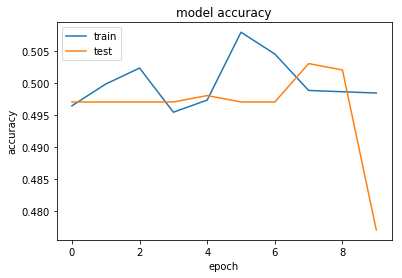

In [77]:
import matplotlib.pyplot as plt
%matplotlib inline
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [78]:
# model.save('mybrandnewmodel.h5')

In [79]:
model.load_weights('chatbot_10.h5')

In [80]:
pred_results=model.predict([inputs_test,queries_test])

In [82]:
test_data[0][0]

['Mary',
 'got',
 'the',
 'milk',
 'there',
 '.',
 'John',
 'moved',
 'to',
 'the',
 'bedroom',
 '.']

In [85]:
pred_results[0]

array([5.7535266e-19, 5.5535609e-19, 5.5276696e-19, 4.4034634e-19,
       7.3216310e-19, 5.6113348e-19, 9.9498677e-01, 5.9364576e-19,
       5.8403206e-19, 5.3241067e-19, 5.5757221e-19, 6.7422246e-19,
       5.9424841e-19, 5.8961946e-19, 5.4788184e-19, 6.3106059e-19,
       4.5307655e-19, 8.3037462e-19, 4.0876658e-19, 5.0132326e-03,
       5.3346987e-19, 5.3976032e-19, 4.7976336e-19, 6.5734916e-19,
       4.1914880e-19, 4.5703259e-19, 3.7400798e-19, 5.7291284e-19,
       5.7225973e-19, 5.4565636e-19, 5.3162117e-19, 5.1036268e-19,
       3.8835378e-19, 4.8711224e-19, 4.5458269e-19, 4.6640780e-19,
       4.5852219e-19, 4.4008769e-19], dtype=float32)

In [86]:
val_max=np.argmax(pred_results[0])

In [88]:
for key,val in tokenizer.word_index.items():
    if val == val_max:
        k=key
        

In [93]:
k

'up'

In [90]:
pred_results[0][val_max]

0.9949868

In [91]:
vocab

{'.',
 '?',
 'Daniel',
 'Is',
 'John',
 'Mary',
 'Sandra',
 'apple',
 'back',
 'bathroom',
 'bedroom',
 'discarded',
 'down',
 'dropped',
 'football',
 'garden',
 'got',
 'grabbed',
 'hallway',
 'in',
 'journeyed',
 'kitchen',
 'left',
 'milk',
 'moved',
 'no',
 'office',
 'picked',
 'put',
 'the',
 'there',
 'to',
 'took',
 'travelled',
 'up',
 'went',
 'yes'}

In [92]:
my_story="John left the kitchen . Sandra dropped the football in the garden ."

In [94]:
my_story.split()

['John',
 'left',
 'the',
 'kitchen',
 '.',
 'Sandra',
 'dropped',
 'the',
 'football',
 'in',
 'the',
 'garden',
 '.']

In [95]:
my_question="Is the football in the garden ?"

In [96]:
my_question.split()

['Is', 'the', 'football', 'in', 'the', 'garden', '?']

In [97]:
mydata = [(my_story.split(),my_question.split(),'yes')]

In [98]:
mydata

[(['John',
   'left',
   'the',
   'kitchen',
   '.',
   'Sandra',
   'dropped',
   'the',
   'football',
   'in',
   'the',
   'garden',
   '.'],
  ['Is', 'the', 'football', 'in', 'the', 'garden', '?'],
  'yes')]

In [99]:
my_story,my_ques,my_ans = vectorize_stories(mydata)

In [100]:
my_story

array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 35,
         1, 20, 33, 16, 18, 23, 20, 17, 29, 20, 24, 16]])

In [101]:
pred_results=model.predict([my_story,my_ques])

In [102]:
val_max=np.argmax(pred_results[0])

In [103]:
for key,val in tokenizer.word_index.items():
    if val == val_max:
        k=key

In [104]:
k

'milk'

In [105]:
pred_results[0][val_max]

0.9667796